# Implement

In [5]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
from project import Projection
from algorithm_CQ import CQ_split_acceptance
from upper_level import optimize_phase2
from problem import Problem
from prettytable import PrettyTable
from utils import visualize_trajectory_generic, visualize_complete_system

import matplotlib.pyplot as plt

import itertools
import pandas as pd

# Define

In [26]:
import autograd.numpy as np

def optim_Scalarization(prob, x_feasible, r, z_star,
                                     max_iter=1000, 
                                     mu=0.1, 
                                     expo_alpha=0.25,
                                     expo_lambda=0.75,
                                     expo_beta=0.85,
                                     init_params=1.0,
                                     verbose=True
                       ):
    """
    Bài toán: Giải quyết bài toán hai cấp bằng phương pháp Neurodynamic/Penalty
    (Không dùng phép chiếu cứng P_C ở bước cập nhật cuối cùng)
    
    Args:
        beta_param (float): Hệ số phạt để kéo x về tập C (nên chọn giá trị dương lớn, vd: 10, 100...)
    """
    
    x_curr = np.array(x_feasible).copy()
    path_x = [x_curr.copy()]
    
    P_C = prob.proj_C
    P_Qplus = prob.proj_Qplus
    if verbose:
        table = PrettyTable()
        table.field_names = ["k", "Alpha_k", "Step_len", "x_curr", "S(F(x))","Gap C", "Gap Q+"]
        table.float_format = ".4"
        table.align = "r" 

    for k in range(max_iter):
        step = k + 1
        
        fx_curr = prob.objective_func(x_curr) 
        J = prob.jacobian(x_curr)             

        # --- 1. Tính Gradient Cấp thấp (v^k) : Giải quyết ràng buộc F(x) in Q+ ---
        proj_q = P_Qplus(fx_curr)
        r_k = fx_curr - proj_q        # Residual vector for Q+
        v_k = J.T @ r_k
        
        # --- 2. Tính Gradient Cấp cao (w^k) : Tối ưu hóa hàm S ---
        weighted_vals = r * (fx_curr - z_star) 
        idx_max = np.argmax(weighted_vals)
        w_k = r[idx_max] * J[idx_max, :]
        
        # --- 3. [MỚI] Tính Gradient Phạt tập C (z^k) : Kéo x về C ---
        # Đạo hàm của 0.5 * ||x - P_C(x)||^2 là (x - P_C(x))
        proj_c_val = P_C(x_curr)
        grad_penalty_C = x_curr - proj_c_val  
        
        # --- 4. Cập nhật tham số ---
        alpha_k = init_params / (step ** expo_alpha)
        lambda_k = init_params / (step ** expo_lambda)
        beta_k = init_params * (step ** expo_beta)
        
        # --- 5. Tổng hợp hướng di chuyển d^k (Total Gradient) ---
        # d^k = Gradient_SFP + alpha * Gradient_Objective + beta * Gradient_ConstraintC
        d_k = v_k + (alpha_k * w_k) + (beta_k * grad_penalty_C)
        
        # --- 6. Tính hệ số chuẩn hóa eta_k ---
        norm_d = np.linalg.norm(d_k)
        eta_k = max(mu, norm_d)
        
        # --- 7. Bước cập nhật (KHÔNG CÒN PHÉP CHIẾU P_C BAO NGOÀI) ---
        step_size = lambda_k / eta_k
        
        # Di chuyển ngược hướng Gradient tổng hợp
        x_next = x_curr - step_size * d_k
        
        path_x.append(x_next.copy())
        x_curr = x_next
        
        # --- Kiểm tra hội tụ ---
        val_S = np.linalg.norm(fx_curr - u_star) 
        viol_q = np.linalg.norm(r_k)            # Vi phạm tập Q+ (ảnh)
        viol_c = np.linalg.norm(grad_penalty_C) # Vi phạm tập C (nguồn) - [MỚI]
        if verbose:
            if k % 10 == 0 or k == max_iter - 1:
                x_str = np.array2string(x_curr, precision=3, separator=',')
                table.add_row([k, f"{alpha_k:.4f}", f"{step_size:.4f}", x_str, val_S, viol_c, viol_q])
        
        # Điều kiện dừng: Gradient nhỏ VÀ các vi phạm ràng buộc đều nhỏ
        if norm_d < 1e-6 and viol_q < 1e-6 and viol_c < 1e-6:
            print(f"-> Thuật toán hội tụ sớm. Sau {k} vòng lặp")
            break
    if verbose:
        print(table)
        final_fx = prob.objective_func(x_curr)
        final_viol_q = np.linalg.norm(final_fx - P_Qplus(final_fx))
        print(f"-> Kết quả cuối cùng Phase 2: {x_curr}")
        print(f"-> S(F(x)): {np.linalg.norm(final_fx - u_star):.4f}")
        print(f"-> Sai số ràng buộc Q+ (Gap): {final_viol_q:.6f}")

    return x_curr, path_x

In [27]:
def f(x):
    return np.array([
        x[0]**2,
       (x[0]-1)**2
    ])

#--------------- C --------------------#


#--------------- Q --------------------#


# Hàm dùng cho Projection 
cons_C = (

)

dim_x = 1

cons_Q = (
 
)

cons_Qplus = (
)
dim_y = 2

In [28]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=None, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jacobian(f)], C=[], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

# Phase 1

In [29]:
# --- Điểm khởi tạo Phase 1 ---
x_init = np.array([-10.0])

print("\n--- PHASE 1: TÌM ĐIỂM KHẢ THI (CQ ALGORITHM) ---")
# Chạy thuật toán CQ có sẵn của bạn
x_feasible, x_hist, f_hist, z_proj_hist = CQ_split_acceptance(
    f=prob.objective_func,
    jac_f=prob.jacobian,
    proj_C=prob.proj_C,
    proj_Qplus=prob.proj_Qplus,
    x0=x_init,
    gamma=0.00055, 
    max_iter=300,
    tol=1e-4
)

print(f"-> Điểm khả thi tìm được sau Phase 1: {x_feasible}")


--- PHASE 1: TÌM ĐIỂM KHẢ THI (CQ ALGORITHM) ---
Khởi tạo: x0: [-10.]
Chiếu lên C được: x: [-10.]


  0%|          | 0/300 [00:00<?, ?it/s]


Hội tụ tại vòng lặp 0
+---+--------+---------+--------------+--------------+----------+----------+
| k | x_new  | gamma_k | y            | z_proj       |   e_x    |   e_f    |
+---+--------+---------+--------------+--------------+----------+----------+
| 0 | [-10.] | 0.0006  | [100., 121.] | [100., 121.] | 0.000000 | 0.000000 |
+---+--------+---------+--------------+--------------+----------+----------+
-> Điểm khả thi tìm được sau Phase 1: [-10.]


Đang xử lý dữ liệu và tạo đồ thị tổng hợp...


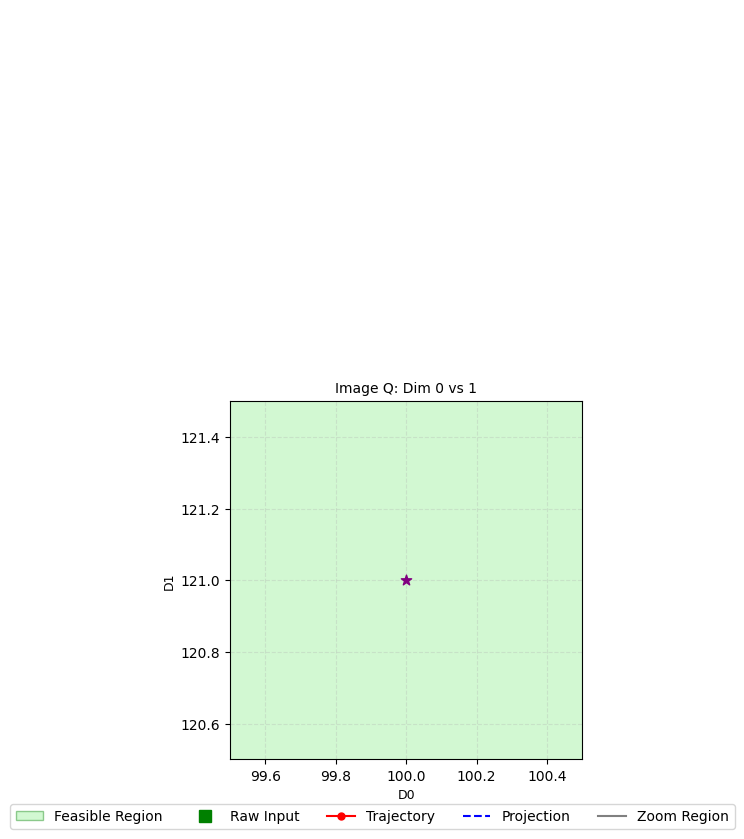

In [30]:
_ = visualize_complete_system(
    x_hist, f_hist, z_proj_hist,
    cons_C, cons_Qplus,
    x0=x_init,   
)

# Test

In [31]:
expo_alpha = 0.35
expo_lambda = 0.65
init_params = 0.5
u_star = np.array([0.0, 0.0])

In [34]:
x_final, path_x = optim_Scalarization(
    prob=prob,
    x_feasible=x_feasible,  
    r=np.array([1.0, 1.0]), 
    z_star=u_star,
    max_iter=1000,
    mu=0.1,
    expo_alpha=expo_alpha,
    expo_lambda=expo_lambda,
    init_params=init_params
)

+-----+---------+----------+----------+----------+--------+--------+
|   k | Alpha_k | Step_len |   x_curr |  S(F(x)) |  Gap C | Gap Q+ |
+-----+---------+----------+----------+----------+--------+--------+
|   0 |  0.5000 |   0.0455 |   [-9.5] | 156.9745 | 0.0000 | 0.0000 |
|  10 |  0.2160 |   0.0274 | [-7.794] | 100.8298 | 0.0000 | 0.0000 |
|  20 |  0.1723 |   0.0249 | [-6.972] |  81.4816 | 0.0000 | 0.0000 |
|  30 |  0.1503 |   0.0240 | [-6.374] |  68.9295 | 0.0000 | 0.0000 |
|  40 |  0.1363 |   0.0237 |  [-5.89] |  59.6116 | 0.0000 | 0.0000 |
|  50 |  0.1263 |   0.0236 | [-5.477] |  52.2329 | 0.0000 | 0.0000 |
|  60 |  0.1186 |   0.0237 | [-5.113] |  46.1620 | 0.0000 | 0.0000 |
|  70 |  0.1125 |   0.0239 | [-4.786] |  41.0390 | 0.0000 | 0.0000 |
|  80 |  0.1074 |   0.0243 | [-4.488] |  36.6377 | 0.0000 | 0.0000 |
|  90 |  0.1031 |   0.0247 | [-4.212] |  32.8059 | 0.0000 | 0.0000 |
| 100 |  0.0994 |   0.0251 | [-3.956] |  29.4359 | 0.0000 | 0.0000 |
| 110 |  0.0962 |   0.0257 | [-3.7

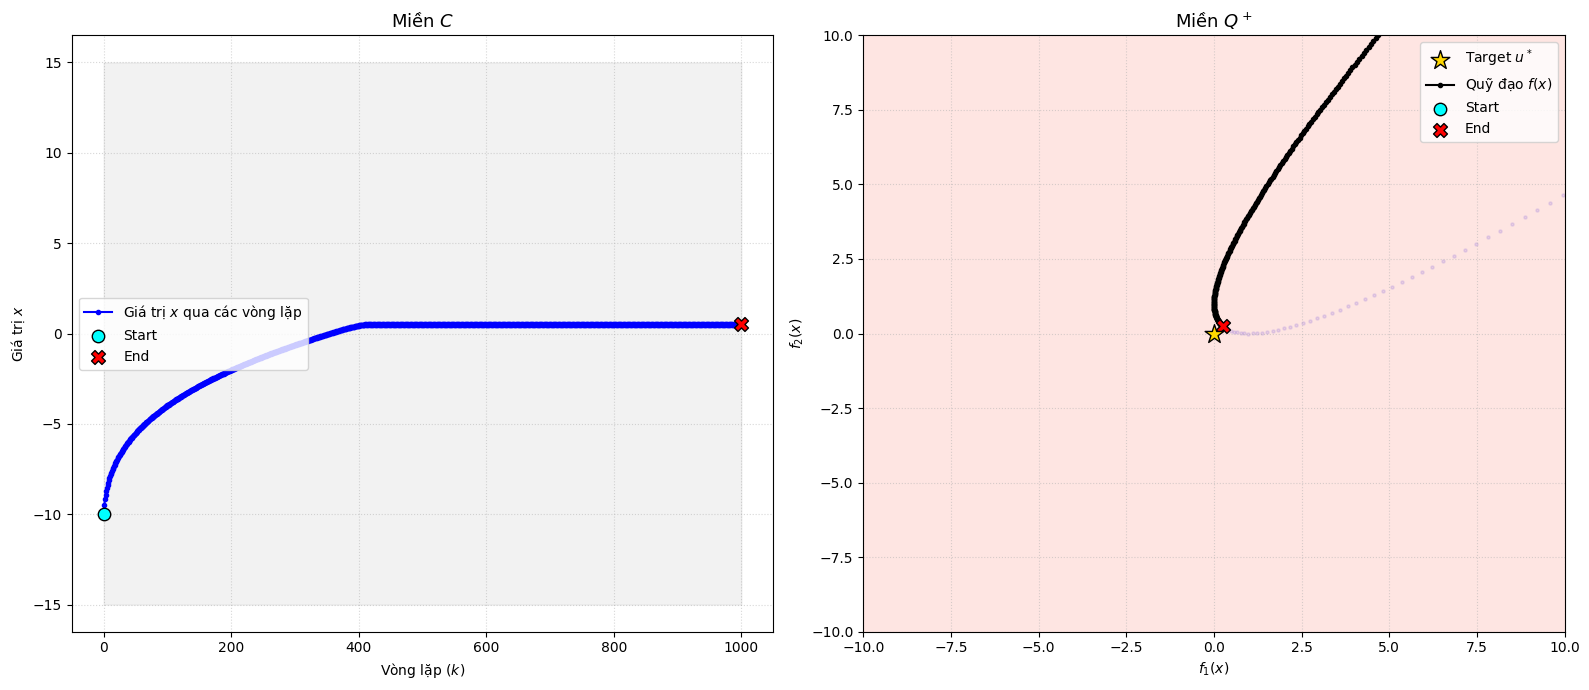

In [42]:
 visualize_trajectory_generic(
        path_x=path_x,
        f_func=f,
        cons_C=cons_C,
        cons_Qplus=cons_Qplus,
        u_star=u_star, 
        x_limits=(-15, 15), 
        y_limits=(-10, 10),
        titles=("Miền $C$", "Miền $Q^+$")
    )

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

def visualize_trajectory_generic(path_x, f_func, 
                                 cons_C, cons_Qplus,
                                 u_star=None,
                                 bounds_x=None, 
                                 x_limits=(-4, 4), 
                                 y_limits=(-4, 4),
                                 titles=None):
    
    # 1. Chuẩn bị dữ liệu
    path_x_arr = np.array(path_x)
    # Đảm bảo path_x_arr có dạng (N, dim_x)
    if path_x_arr.ndim == 1:
        path_x_arr = path_x_arr.reshape(-1, 1)
        
    dim_x = path_x_arr.shape[1]
    path_f_arr = np.array([f_func(p).flatten() for p in path_x_arr])

    # 2. Khởi tạo khung hình
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    title_x = "Không gian biến $X$"
    title_y = "Không gian ảnh $Y$ (Miền $Q^+$)"
    if titles:
        if len(titles) >= 1: title_x = titles[0]
        if len(titles) >= 2: title_y = titles[1]

    # =========================================================
    # HÌNH 1: KHÔNG GIAN BIẾN X (Xử lý 1D và 2D)
    # =========================================================
    ax1.set_title(title_x, fontsize=13)
    res = 500 

    if dim_x >= 2:
        # --- TRƯỜNG HỢP 2D: Vẽ quỹ đạo x1, x2 ---
        x1_vals = np.linspace(x_limits[0], x_limits[1], res)
        x2_vals = np.linspace(x_limits[0], x_limits[1], res)
        X1, X2 = np.meshgrid(x1_vals, x2_vals)
        grid_points_X = np.vstack([X1.ravel(), X2.ravel()]).T
        
        mask_C = check_constraints(grid_points_X, cons_C, bounds_x).reshape(X1.shape)
        
        ax1.contourf(X1, X2, mask_C, levels=[0.5, 1.5], colors=['skyblue'], alpha=0.4)
        ax1.contour(X1, X2, mask_C, levels=[0.5], colors='blue', linewidths=1.5)
        
        ax1.plot(path_x_arr[:, 0], path_x_arr[:, 1], 'k.-', linewidth=1.5, label='Quỹ đạo $x$', zorder=2)
        ax1.set_xlabel("$x_1$"); ax1.set_ylabel("$x_2$")
    else:
        # --- TRƯỜNG HỢP 1D: Vẽ x theo thời gian (k) ---
        k_indices = np.arange(len(path_x_arr))
        ax1.plot(k_indices, path_x_arr[:, 0], 'b.-', linewidth=1.5, label='Giá trị $x$ qua các vòng lặp')
        
        # Vẽ vùng C (nếu có ràng buộc 1D)
        test_x = np.linspace(x_limits[0], x_limits[1], res).reshape(-1, 1)
        mask_C_1d = check_constraints(test_x, cons_C, bounds_x)
        # Tô màu các vùng khả thi trên trục tung
        ax1.fill_between(k_indices, x_limits[0], x_limits[1], where=None, color='gray', alpha=0.1) 
        
        ax1.set_xlabel("Vòng lặp ($k$)")
        ax1.set_ylabel("Giá trị $x$")
        # Điểm Start/End trong đồ thị 1D
        ax1.scatter(0, path_x_arr[0, 0], c='cyan', s=80, edgecolors='k', label='Start', zorder=5)
        ax1.scatter(k_indices[-1], path_x_arr[-1, 0], c='red', s=100, marker='X', edgecolors='k', label='End', zorder=5)

    if dim_x >= 2:
        ax1.scatter(path_x_arr[0, 0], path_x_arr[0, 1], c='cyan', s=80, edgecolors='k', label='Start', zorder=5)
        ax1.scatter(path_x_arr[-1, 0], path_x_arr[-1, 1], c='red', s=100, marker='X', edgecolors='k', label='End', zorder=5)
        ax1.set_xlim(x_limits); ax1.set_ylim(x_limits)
    
    ax1.grid(True, linestyle=':', alpha=0.5); ax1.legend(loc='best')

    # =========================================================
    # HÌNH 2: KHÔNG GIAN ẢNH Y (Luôn là 2D vì f(x) có 2 mục tiêu)
    # =========================================================
    ax2.set_title(title_y, fontsize=13)

    y1_vals = np.linspace(y_limits[0], y_limits[1], res)
    y2_vals = np.linspace(y_limits[0], y_limits[1], res)
    Y1, Y2 = np.meshgrid(y1_vals, y2_vals)
    grid_points_Y = np.vstack([Y1.ravel(), Y2.ravel()]).T
    
    mask_Q = check_constraints(grid_points_Y, cons_Qplus, None).reshape(Y1.shape)
    ax2.contourf(Y1, Y2, mask_Q, levels=[0.5, 1.5], colors=['salmon'], alpha=0.2)
    ax2.contour(Y1, Y2, mask_Q, levels=[0.5], colors='red', linewidths=1.5, linestyles='--')
    
    # --- VẼ ĐÁM MÂY f(C) ---
    # Lấy mẫu điểm trong C để vẽ ảnh
    if dim_x >= 2:
        points_in_C = grid_points_X[mask_C.ravel() > 0.5]
    else:
        points_in_C = test_x[mask_C_1d > 0.5]

    num_samples = 20000 
    if len(points_in_C) > num_samples:
        indices = np.random.choice(len(points_in_C), num_samples, replace=False)
        sample_C = points_in_C[indices]
    else:
        sample_C = points_in_C
        
    if len(sample_C) > 0:
        sample_fC = np.array([f_func(p).flatten() for p in sample_C])
        ax2.scatter(sample_fC[:, 0], sample_fC[:, 1], c='mediumpurple', s=5, alpha=0.2, zorder=1)

    # --- VẼ ĐIỂM MỤC TIÊU U_STAR ---
    if u_star is not None:
        ax2.scatter(u_star[0], u_star[1], c='gold', s=200, marker='*', edgecolors='k', zorder=10, label='Target $u^*$')

    # --- VẼ QUỸ ĐẠO f(x) ---
    ax2.plot(path_f_arr[:, 0], path_f_arr[:, 1], 'k.-', linewidth=1.5, label='Quỹ đạo $f(x)$', zorder=2)
    ax2.scatter(path_f_arr[0, 0], path_f_arr[0, 1], c='cyan', s=80, edgecolors='k', label='Start', zorder=5)
    ax2.scatter(path_f_arr[-1, 0], path_f_arr[-1, 1], c='red', s=100, marker='X', edgecolors='k', label='End', zorder=5)

    ax2.set_xlim(y_limits); ax2.set_ylim(y_limits)
    ax2.set_xlabel("$f_1(x)$"); ax2.set_ylabel("$f_2(x)$")
    ax2.grid(True, linestyle=':', alpha=0.5); ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

In [40]:
def check_constraints(points, constraints, bounds=None):
    """
    Hàm phụ trợ kiểm tra constraints (Đã sửa lỗi shapes).
    """
    n_points = points.shape[0]
    is_feasible = np.ones(n_points, dtype=bool)
    
    # 1. Kiểm tra Bounds
    if bounds is not None:
        if isinstance(bounds, (list, tuple)):
            for i, b in enumerate(bounds):
                if b is not None:
                    if b[0] is not None: is_feasible &= (points[:, i] >= b[0])
                    if b[1] is not None: is_feasible &= (points[:, i] <= b[1])
    
    # 2. Kiểm tra Constraints
    if constraints:
        for cons in constraints:
            vals = None
            
            try:
                res = cons['fun'](points.T)                 
                if res.ndim == 2 and res.shape[1] == n_points:
                    vals = res.T
                elif res.ndim == 1 and res.shape[0] == n_points:
                    vals = res
            except:
                pass
            # B. Fallback: Loop từng điểm (chậm nhưng chắc)
            if vals is None:
                vals = np.array([cons['fun'](p) for p in points])
            # C. Xử lý logic Đa ràng buộc (Multi-constraints)
            if vals.ndim > 1:
                if cons['type'] == 'ineq':
                    vals = np.min(vals, axis=1) 
                elif cons['type'] == 'eq':
                    vals = np.max(np.abs(vals), axis=1)

            # D. So sánh cập nhật mask
            if vals.shape[0] != n_points:
                print(f"Warning: Shape mismatch in constraint check. Expected {n_points}, got {vals.shape}")
                continue

            if cons['type'] == 'ineq':
                is_feasible &= (vals >= -1e-5)
            elif cons['type'] == 'eq':
                if vals.ndim == 1 and np.any(vals < 0): # Check sơ bộ
                     is_feasible &= (np.abs(vals) <= 1e-3)
                else:
                     is_feasible &= (vals <= 1e-3)

    return is_feasible

---

In [ ]:
x = [-0.1239, -0.0699]

In [ ]:
f(x)